# EEG Preprocessing and Visualization Script

This script loads raw EEG data for each subject, applies preprocessing (including referencing and bandpass filtering), computes power spectral density (PSD) plots, and extracts time-window snapshots of the raw data. The resulting figures are saved to subject-specific directories.

---

## Workflow Overview

1. **Directory Setup and File Checking:**
   - For each subject, the script creates directories for storing timeseries and PSD plots.
   - It constructs the file path to load the raw EEG FIF file from a preprocessed derivatives folder.
   - If the file does not exist, the script prints a warning and skips the subject.

2. **Data Loading and Preprocessing:**
   - The raw EEG data is loaded using `read_raw_fif` with preloading enabled and limited to EEG channels.
   - A common average reference is applied.
   - Two versions of the raw data are prepared:
     - **Raw broadband data**.
     - **Bandpass-filtered data:** A copy of the raw data filtered between 0.5 and 8 Hz.

3. **PSD Computation and Saving:**
   - PSD plots are computed and saved for both versions of the data:
     - **All sensors:**
       - Bandpass-filtered data with `fmax=10 Hz`.
       - Broadband data with `fmax=80 Hz`.
     - **Selected channels (Hubner set):**
       - Bandpass-filtered data with `fmax=10 Hz`.
       - Broadband data with `fmax=80 Hz`.

4. **Snapshot Visualization:**
   - The total duration of the raw recording is determined.
   - The script randomly selects 15 starting points (with reproducibility ensured by seeding) for 50-second window snapshots.
   - For each window, two snapshots are generated and saved:
     - One from the bandpass-filtered data.
     - One from the broadband data.

---

In [2]:
import os
import mne
import numpy as np

mne.set_log_level('warning')
wd = r'C:\Users\Radovan\OneDrive\Radboud\Studentships\Jordy Thielen\root'
os.chdir(wd)
from os.path import join
data_dir = join(wd, "data")
experiment_dir = join(data_dir, "experiment")
files_dir = join(experiment_dir, 'files')
sourcedata_dir = join(experiment_dir, 'sourcedata')
derivatives_dir = join(experiment_dir, 'derivatives')
preprocessed_dir = join(derivatives_dir, 'preprocessed')
analysis_dir = join(data_dir, "analysis")
raw_dir = join(analysis_dir, 'raw')

# List of subjects to process
subjects = [
    "VPpdia", "VPpdib", "VPpdic", "VPpdid", "VPpdie", "VPpdif",  "VPpdig", "VPpdih",
    "VPpdii", "VPpdij", "VPpdik", "VPpdil", "VPpdim", "VPpdin", "VPpdio", "VPpdip", "VPpdiq", "VPpdir", "VPpdis",
    "VPpdit","VPpdiu", "VPpdiv", "VPpdiw", "VPpdix", "VPpdiy", "VPpdiz", "VPpdiza", "VPpdizb", "VPpdizc"
    ]

picks_hubner = [
    "F7", "F3", "Fz", "F4", "F8", "FC1", "FC2", "FC5", "FC6", "FCz", "T7", "C3", 
    "Cz", "C4", "T8", "CP1", "CP2", "CP5", "CP6", "CPz",
    "P7", "P3", "Pz", "P4", "P8", "Oz", "O1", "O2"
]

C:\Users\Radovan\AppData\Local\Temp\ipykernel_39604\3894742451.py:43: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  psd1_fig = psd1.plot(show=False)
C:\Users\Radovan\AppData\Local\Temp\ipykernel_39604\3894742451.py:49: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  psd2_fig = psd2.plot(show=False)
C:\Users\Radovan\AppData\Local\Temp\ipykernel_39604\3894742451.py:60: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  psd3_fig = psd3.plot(show=False)
C:\Users\Radovan\AppData\Local\Temp\ipykernel_39604\3894742451.py:66: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  psd4_fig = psd4.plot(show=False)


KeyboardInterrupt: 

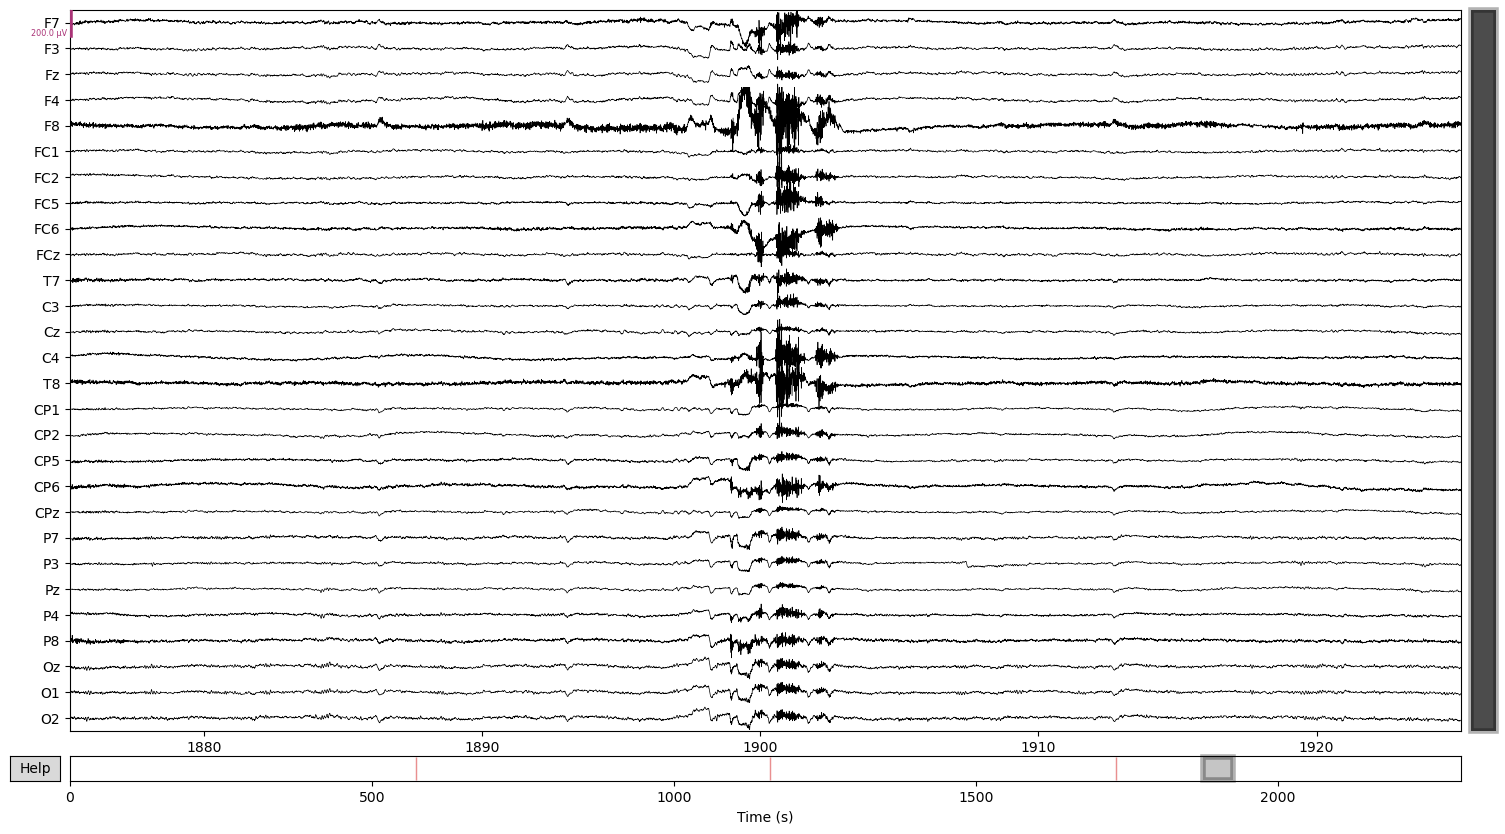

In [ ]:
import os
import numpy as np
from mne.io import read_raw_fif
import matplotlib.pyplot as plt

# Define your task and directories
task = "covert"  # Replace with the task name

# Function to ensure a directory exists
def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)


# Time window duration in seconds
time_window = 50  

# Loop through each subject
for subject in subjects:
    subj_dir = os.path.join(raw_dir, f"sub-{subject}")
    ts_dir = join(subj_dir, 'timeseries')
    psd_dir = join(subj_dir, 'psd')
    ensure_dir(subj_dir)  # Ensure the subject directory exists
    ensure_dir(ts_dir)
    ensure_dir(psd_dir)

    file_path =os.path.join(derivatives_dir, "preprocessed", "raw", f"sub-{subject}", f"sub-{subject}_task-{task}_raw.fif")
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue
    # Load and preprocess the raw data
    raw = read_raw_fif(file_path, preload=True).pick('eeg')
    raw.set_eeg_reference(ref_channels='average', projection=False, verbose=None)
    #raw.filter(0.1, 250)
    raw_bandpass = raw.copy().filter(0.5, 8)

   
    # PSD 0.5–8 Hz, fmax 10
    psd1 = raw_bandpass.compute_psd(fmax=10)
    psd1_fig = psd1.plot(show=False)
    psd1_fig.savefig(os.path.join(psd_dir, f"sub-{subject}_psd_bandpass_allsensors.png"))
    plt.close(psd1_fig)
    
    # PSD full, fmax 80
    psd2 = raw.compute_psd(fmax=80)
    psd2_fig = psd2.plot(show=False)
    psd2_fig.savefig(os.path.join(psd_dir, f"sub-{subject}_psd_broadband_allsensors.png"))
    plt.close(psd2_fig)


    # Pick specific channels (Hubner set) for both raws
    raw.pick(picks_hubner)
    raw_bandpass.pick(picks_hubner)

    # PSD 0.5–8 Hz with specific picks, fmax 10
    psd3 = raw_bandpass.compute_psd(fmax=10)
    psd3_fig = psd3.plot(show=False)
    psd3_fig.savefig(os.path.join(psd_dir, f"sub-{subject}_psd_bandpass_subset.png"))
    plt.close(psd3_fig)
    
    # PSD full with specific picks, fmax 80
    psd4 = raw.compute_psd(fmax=80)
    psd4_fig = psd4.plot(show=False)
    psd4_fig.savefig(os.path.join(psd_dir, f"sub-{subject}_psd_broadband_subset.png"))
    plt.close(psd4_fig)
    
    
    # Get the total duration of the raw data in seconds
    duration = raw.times[-1]  # Last time point in seconds
    
    # Randomly choose 10 start points for 20-second windows
    np.random.seed(42)  # For reproducibility
    start_points = np.random.uniform(0, duration - time_window, 15)
    
    for i, start in enumerate(start_points):
        # Set the time window for the snapshot
        end = start + time_window
    
        # Plot the data for the given time window
        fig_bp = raw_bandpass.plot(start=start, duration=time_window,show_scrollbars=True, scalings=dict(eeg=50e-6),
                            n_channels = len(raw_bandpass.ch_names), show=False, title=f"Subject {subject} - Snapshot {i+1}")
        
        fig_bb = raw.plot(start=start, duration=time_window,show_scrollbars=True, scalings=dict(eeg=100e-6),
                            n_channels = len(raw.ch_names), show=False, title=f"Subject {subject} - Snapshot {i+1}")
        # Save the figure
        fig_bp.savefig(os.path.join(ts_dir, f"sub-{subject}_bandpass_snapshot_{i+1}.png"))
        plt.close(fig_bp)
        fig_bb.savefig(os.path.join(ts_dir, f"sub-{subject}_broadband_snapshot_{i+1}.png"))
        plt.close(fig_bb)


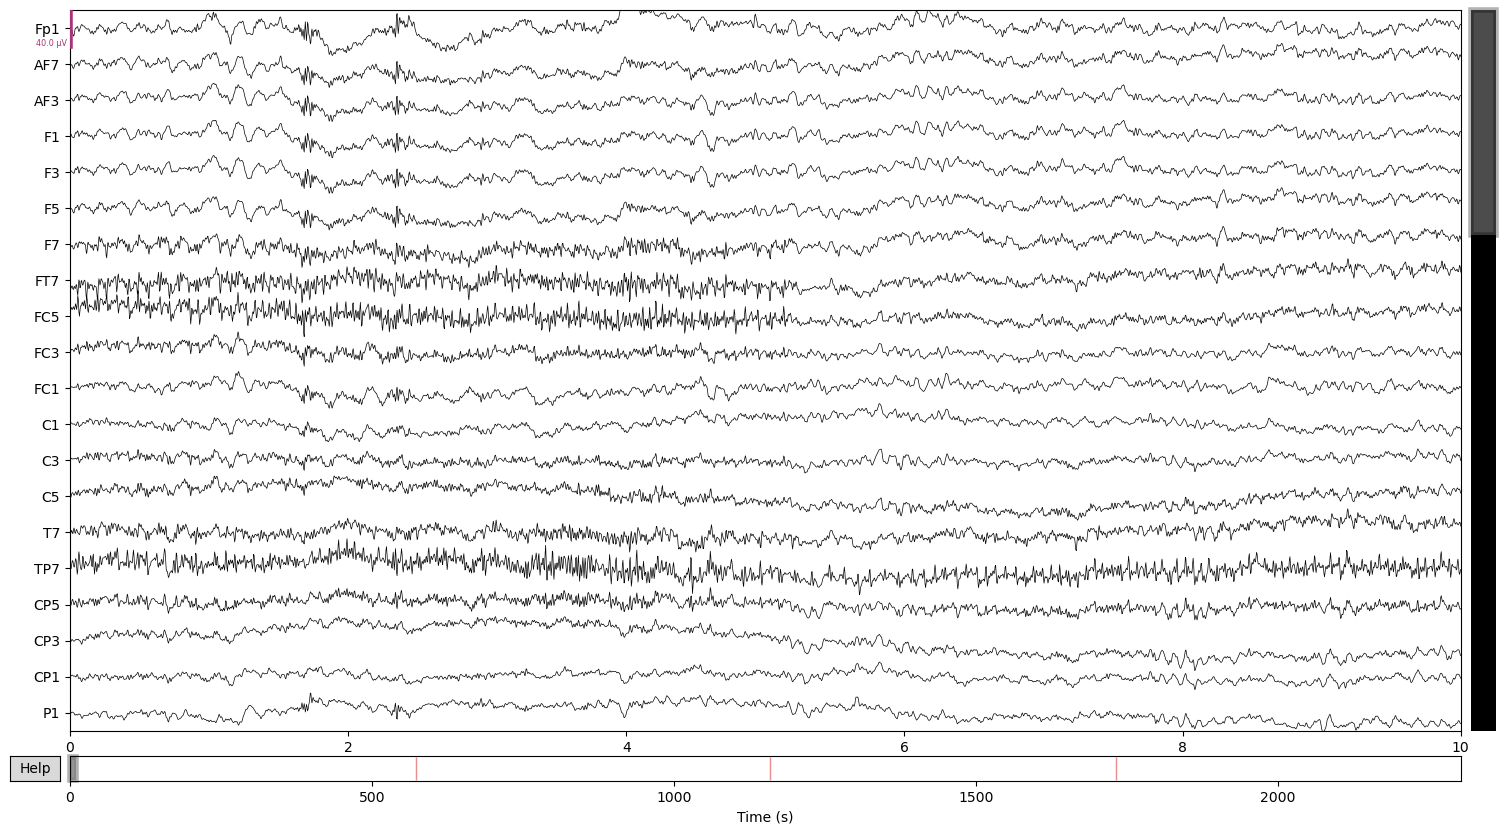

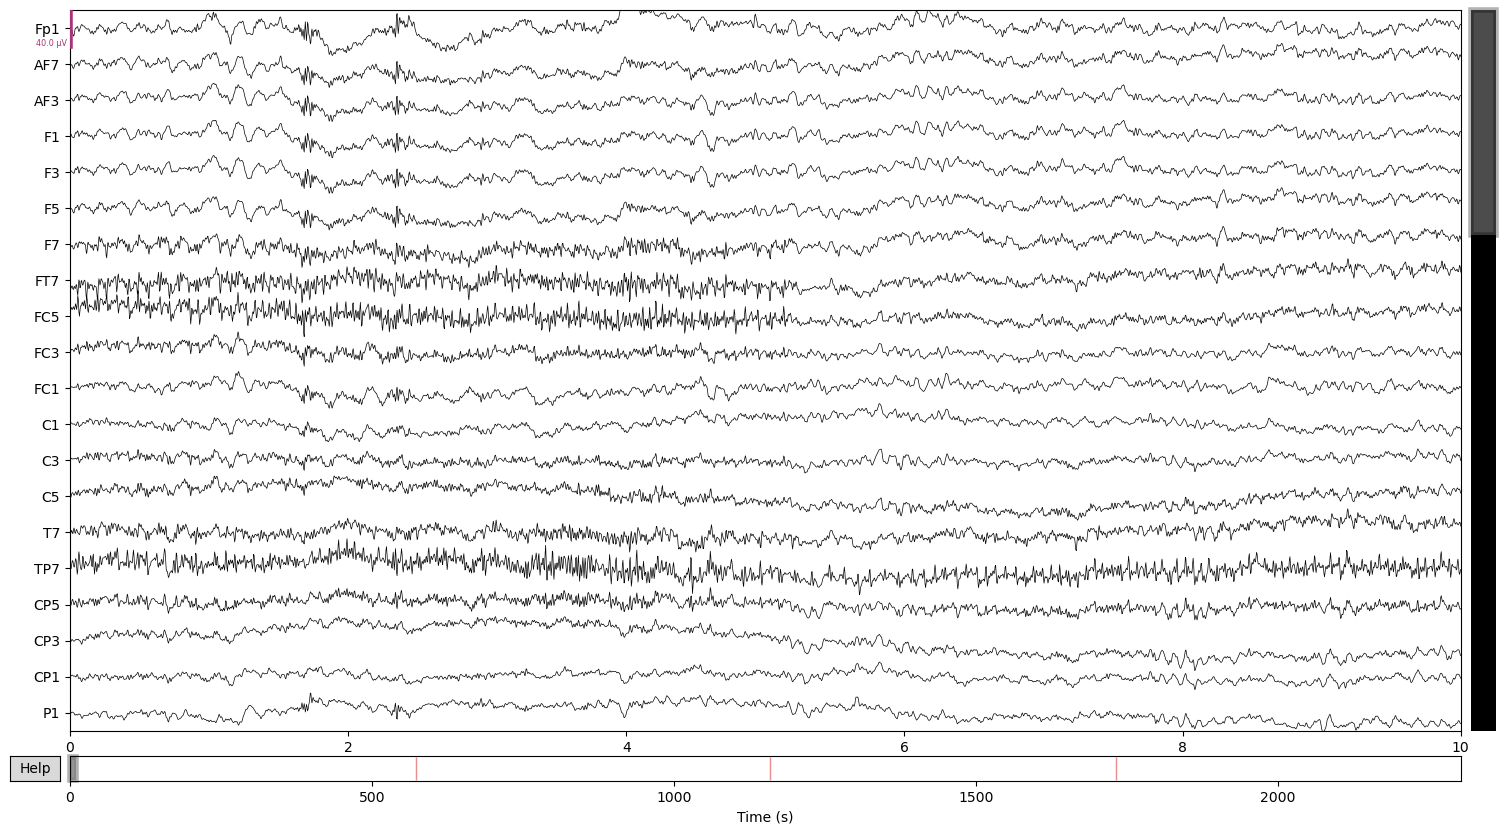

In [9]:
raw.plot()